In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [2]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward0>)


In [17]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
# [(['forty', 'When'], 'winters'), (['winters', 'forty'], 'shall'), (['shall', 'winters'], 'besiege')]
test_sentence = """가수 G-DRAGON 8년 만에 '가요대전'에 출격한다.

11일 SBS 측에 따르면 '2024 SBS 가요대전'의 최종 라인업 아티스트로 G-DRAGON이 깜짝 공개됐다. G-DRAGON 최근 신곡 'POWER' 및 'HOME SWEET HOME'을 발표하며 7년 만에 컴백, 주요 음원 차트 1위를 석권하는 등 연일 돌풍을 일으키고 있다. 이에 더해 G-DRAGON은 8년 만에 '가요대전' 라인업에 이름을 올리며 크리스마스 K팝 축제의 열기를 배가시킬 전망이다.

'2024 SBS 가요대전'의 최종 라인업에는 G-DRAGON 키 (KEY), 2NE1, NCT 127, NCT DREAM, Stray Kids (스트레이 키즈), (여자)아이들, ATEEZ (에이티즈), WayV, ITZY, 투모로우바이투게더, 이영지, CRAVITY, TREASURE (트레저), aespa, ENHYPEN (엔하이픈), IVE, NMIXX, LE SSERAFIM, 뉴진스 (NewJeans), BOYNEXTDOOR, ZEROBASEONE, 라이즈 (RIIZE), TWS (투어스), NCT WISH, 아일릿 (ILLIT), BABYMONSTER, NEXZ, izna (이즈나)까지 총 29팀이 출연을 확정지으며, 역대 최고 수준의 초호화 아티스트 라인업을 완성시켰다.

'2024 SBS 가요대전'은 오는 12월 25일(수) 인천 영종도 인스파이어 아레나에서 개최되며, SBS를 통해 생방송으로 중계된다.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
# Print the first 3, just so you can see what they look like.
print(ngrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


[(['G-DRAGON', '가수'], '8년'), (['8년', 'G-DRAGON'], '만에'), (['만에', '8년'], "'가요대전'에")]


In [18]:
word_to_ix

{'열기를': 0,
 "'가요대전'에": 1,
 '차트': 2,
 '완성시켰다.': 3,
 '및': 4,
 '석권하는': 5,
 '7년': 6,
 'aespa,': 7,
 '역대': 8,
 '아티스트': 9,
 'ATEEZ': 10,
 '이름을': 11,
 '라인업에는': 12,
 '(여자)아이들,': 13,
 '발표하며': 14,
 '초호화': 15,
 '라이즈': 16,
 '주요': 17,
 '확정지으며,': 18,
 '(이즈나)까지': 19,
 '축제의': 20,
 '중계된다.': 21,
 'G-DRAGON은': 22,
 '127,': 23,
 'IVE,': 24,
 'K팝': 25,
 '(투어스),': 26,
 "'HOME": 27,
 '측에': 28,
 '(엔하이픈),': 29,
 '개최되며,': 30,
 '뉴진스': 31,
 '총': 32,
 'G-DRAGON이': 33,
 'SBS를': 34,
 'ITZY,': 35,
 '키즈),': 36,
 'WayV,': 37,
 "가요대전'의": 38,
 '(ILLIT),': 39,
 'LE': 40,
 "'가요대전'": 41,
 'TWS': 42,
 '오는': 43,
 '2NE1,': 44,
 '연일': 45,
 'CRAVITY,': 46,
 'TREASURE': 47,
 '공개됐다.': 48,
 '라인업을': 49,
 '11일': 50,
 '수준의': 51,
 '이영지,': 52,
 '인스파이어': 53,
 '컴백,': 54,
 '25일(수)': 55,
 'NEXZ,': 56,
 '인천': 57,
 'Kids': 58,
 'BABYMONSTER,': 59,
 'NCT': 60,
 '더해': 61,
 '(트레저),': 62,
 '이에': 63,
 "'2024": 64,
 '신곡': 65,
 '최종': 66,
 'BOYNEXTDOOR,': 67,
 'SWEET': 68,
 'NMIXX,': 69,
 '일으키고': 70,
 '8년': 71,
 'SBS': 72,
 '최근': 73,
 '따르면': 74,
 '아일

In [19]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [20]:
for epoch in range(100):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

[619.8925218582153, 617.1889810562134, 614.4966053962708, 611.8148093223572, 609.1419005393982, 606.4770166873932, 603.818407535553, 601.1650605201721, 598.5151822566986, 595.8698978424072, 593.2272083759308, 590.5874292850494, 587.9482004642487, 585.3081421852112, 582.6675412654877, 580.0259912014008, 577.3835825920105, 574.7375257015228, 572.0875272750854, 569.4350204467773, 566.7791664600372, 564.11781001091, 561.4506266117096, 558.7773303985596, 556.0960683822632, 553.4071743488312, 550.7111964225769, 548.0056879520416, 545.2911996841431, 542.5665214061737, 539.8322410583496, 537.0872260332108, 534.3316757678986, 531.5651103258133, 528.7874463796616, 525.9997460842133, 523.1998578310013, 520.3876874446869, 517.5625193119049, 514.7268480062485, 511.879355430603, 509.0212973356247, 506.1490545272827, 503.26407063007355, 500.3672295808792, 497.4581776857376, 494.5370223522186, 491.60432612895966, 488.6585758924484, 485.69973862171173, 482.72573721408844, 479.73823523521423, 476.735761

In [31]:
a = model.embeddings.weight[word_to_ix['G-DRAGON']]

In [30]:
b= model.embeddings.weight[word_to_ix['열기를']]

In [32]:
torch.dot(a, b)

tensor(1.6216, grad_fn=<DotBackward0>)

In [40]:
import numpy as np
a = model.embeddings.weight[word_to_ix['G-DRAGON']]
result = {}
for x in word_to_ix.keys():
    b= model.embeddings.weight[word_to_ix[x]]
    result[x] = torch.dot(a, b)

In [43]:
sorted(result.items(), key=lambda x : x[1], reverse=True)

[('G-DRAGON', tensor(28.1829, grad_fn=<DotBackward0>)),
 ('8년', tensor(17.2025, grad_fn=<DotBackward0>)),
 ('SBS를', tensor(10.1260, grad_fn=<DotBackward0>)),
 ('7년', tensor(9.5767, grad_fn=<DotBackward0>)),
 ('투모로우바이투게더,', tensor(7.6274, grad_fn=<DotBackward0>)),
 ('SSERAFIM,', tensor(7.2082, grad_fn=<DotBackward0>)),
 ('아티스트로', tensor(7.1892, grad_fn=<DotBackward0>)),
 ('LE', tensor(7.0519, grad_fn=<DotBackward0>)),
 ('12월', tensor(6.8132, grad_fn=<DotBackward0>)),
 ('WayV,', tensor(6.5804, grad_fn=<DotBackward0>)),
 ('DREAM,', tensor(6.5628, grad_fn=<DotBackward0>)),
 ('음원', tensor(6.4346, grad_fn=<DotBackward0>)),
 ('(트레저),', tensor(6.0577, grad_fn=<DotBackward0>)),
 ('(NewJeans),', tensor(5.9254, grad_fn=<DotBackward0>)),
 ('라인업에', tensor(5.6975, grad_fn=<DotBackward0>)),
 ('최고', tensor(5.5797, grad_fn=<DotBackward0>)),
 ("'가요대전'에", tensor(5.4787, grad_fn=<DotBackward0>)),
 ('TWS', tensor(4.9594, grad_fn=<DotBackward0>)),
 ('Stray', tensor(4.6614, grad_fn=<DotBackward0>)),
 ('생방송으로

In [33]:
a = model.embeddings.weight[word_to_ix['G-DRAGON']]
for x in word_to_ix.keys():
    b= model.embeddings.weight[word_to_ix[x]]
    print(f"G-DRAGON 유사도 값 : {x} -> {torch.dot(a, b)} ")

G-DRAGON 유사도 값 : 열기를 -> 1.621586799621582 
G-DRAGON 유사도 값 : '가요대전'에 -> 5.478748798370361 
G-DRAGON 유사도 값 : 차트 -> -7.356228828430176 
G-DRAGON 유사도 값 : 완성시켰다. -> -8.813652038574219 
G-DRAGON 유사도 값 : 및 -> -3.9944851398468018 
G-DRAGON 유사도 값 : 석권하는 -> 1.8105392456054688 
G-DRAGON 유사도 값 : 7년 -> 9.57669448852539 
G-DRAGON 유사도 값 : aespa, -> -0.2518100142478943 
G-DRAGON 유사도 값 : 역대 -> -2.404710531234741 
G-DRAGON 유사도 값 : 아티스트 -> -4.371670722961426 
G-DRAGON 유사도 값 : ATEEZ -> 0.8676426410675049 
G-DRAGON 유사도 값 : 이름을 -> -4.0559611320495605 
G-DRAGON 유사도 값 : 라인업에는 -> 0.15728874504566193 
G-DRAGON 유사도 값 : (여자)아이들, -> -2.027121067047119 
G-DRAGON 유사도 값 : 발표하며 -> 3.9560718536376953 
G-DRAGON 유사도 값 : 초호화 -> 0.5523124933242798 
G-DRAGON 유사도 값 : 라이즈 -> -9.685728073120117 
G-DRAGON 유사도 값 : 주요 -> 3.5853285789489746 
G-DRAGON 유사도 값 : 확정지으며, -> -16.007038116455078 
G-DRAGON 유사도 값 : (이즈나)까지 -> -2.658299684524536 
G-DRAGON 유사도 값 : 축제의 -> -7.6474690437316895 
G-DRAGON 유사도 값 : 중계된다. -> -5.348903656005859 
G-DRA

In [21]:
print(model.embeddings.weight[word_to_ix["G-DRAGON"]])

tensor([ 0.2882, -0.4441,  4.0329,  2.5488,  1.4405, -0.7433, -1.2239, -0.9416,
         0.3602,  0.0075], grad_fn=<SelectBackward0>)


In [ ]:
pip install timm

In [45]:
import timm

In [48]:
model = timm.create_model('vgg16', pretrained=True)

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

In [49]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [57]:
import os, glob, random

In [ ]:
random.shuffle(glob.glob("./food_data/곱창전골/*.jpg"))

In [68]:
data1  = glob.glob("./food_data/곱창전골/*.jpg")

In [75]:
random.seed(1)
random.shuffle(data1)

In [76]:
data1[:5]

['./food_data/곱창전골/Img_105_0300.jpg',
 './food_data/곱창전골/Img_105_0396.jpg',
 './food_data/곱창전골/Img_105_0984.jpg',
 './food_data/곱창전골/Img_105_0412.jpg',
 './food_data/곱창전골/Img_105_0530.jpg']

In [77]:
glob.glob("./food_data/물회/*.jpg").__len__()

1013

In [78]:
glob.glob("./food_data/육회/*.jpg").__len__()

1000

In [79]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

# 입력 화상의 전처리 클래스
class BaseTransform():
    """
    화상의 크기를 리사이즈하고 색상을 표준화한다.

    Attributes
    ----------
    resize : int
        리사이즈 대상 이미지의 크기.
    mean : (R, G, B)
        각 색상 채널의 평균 값.
    std : (R, G, B)
        각 색상 채널의 표준 편차.
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # 짧은 변의 길이가 resize의 크기가 된다
            transforms.CenterCrop(resize),  # 이미지 중앙을 resize × resize으로 자르기
            transforms.ToTensor(),  # Torch 텐서로 변환
            transforms.Normalize(mean, std)  # 색상 정보의 표준화
        ])

    def __call__(self, img):
        return self.base_transform(img)


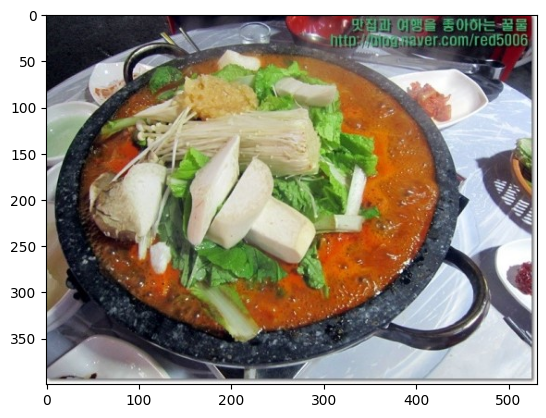

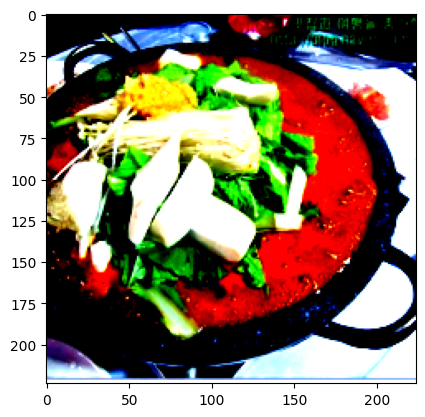

In [84]:
image_file_path = './food_data/곱창전골/Img_105_0300.jpg'
img = Image.open(image_file_path)   # [높이][폭][색RGB]

# 2. 원본 화상 표시
plt.imshow(img)
plt.show()

# 3. 화상 전처리, 처리된 화상을 표시
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = BaseTransform(size, mean, std)
img_transformed = transform(img)  # torch.Size([3, 224, 224])

# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0-1로 값을 제한해 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


In [87]:
os.listdir("./food_data/")

['곱창전골', '물회', '육회']

In [89]:
# 훈련/검증 데이터 8:2로 경로 반환 
def make_datapath_list():
    rootpath = "./food_data"
    # ['곱창전골', '물회', '육회']
    train_data = []
    val_data = []
    for target_dir in os.listdir(rootpath):
        target_path = f"{rootpath}/{target_dir}/*.jpg"
        tmp = glob.glob(target_path)
        random.shuffle(tmp)
        train_data.extend(tmp[:800])
        val_data.extend(tmp[800:1000])
    return train_data, val_data

In [ ]:
train_list, val_list = make_datapath_list()

In [97]:
train_list[0].split("/")[2]

'곱창전골'

In [120]:
import torch.utils.data as data
class FoodDataset(data.Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list  # 파일 경로 리스트
        self.transform = transform  # 전처리 클래스의 인스턴스

    def __len__(self):
        '''화상 개수를 반환'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 Tensor 형식의 데이터와 라벨을 취득
        '''

        # index번째의 화상을 로드
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][너비][색RGB]

        # 화상의 전처리를 실시
        img_transformed = self.transform(img)  # torch.Size([3, 224, 224])

        # 화상 라벨을 파일 이름에서 추출
        label = img_path.split("/")[2]

        # 라벨을 숫자로 변경
        if label == "곱창전골":
            label = 0
        elif label == "물회":
            label = 1
        elif label == '육회':
            label = 2

        return img_transformed, label


In [123]:
std

(0.229, 0.224, 0.225)

In [124]:
transform=BaseTransform(size, mean, std)

In [129]:
train_dataset = FoodDataset(train_list, transform=BaseTransform(size, mean, std))
val_dataset = FoodDataset(val_list, transform=BaseTransform(size, mean, std))

In [130]:
val_dataset.__len__()

600

In [128]:
len(train_dataset)

2400

In [118]:
a[-1][0].shape

(224, 224, 3)

In [119]:
a[-1][1]

2

In [131]:
batch_size = 32

# DataLoader 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

In [132]:
# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # 반복자(iterator)로 변환
inputs, labels = next(
    batch_iterator)  # 첫번째 요소를 추출
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([2, 2, 0, 1, 0, 0, 1, 0, 0, 2, 2, 1, 2, 2, 2, 2, 0, 0, 1, 1, 0, 2, 1, 2,
        1, 2, 2, 2, 1, 0, 2, 1])


In [145]:
model.head

ClassifierHead(
  (global_pool): SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
  (drop): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=4096, out_features=1000, bias=True)
  (flatten): Identity()
)

In [ ]:
model.head.fc = nn.Linear(in_features=4096, out_features=3)

# 훈련 모드로 설정
model.train()

print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

criterion = nn.CrossEntropyLoss()

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


In [147]:
criterion = nn.CrossEntropyLoss()

In [150]:
for name, param in model.named_parameters():
    print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
pre_logits.fc1.weight
pre_logits.fc1.bias
pre_logits.fc2.weight
pre_logits.fc2.bias
head.fc.weight
head.fc.bias


In [151]:
# 전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장한다
params_to_update = []

# 학습시킬 파라미터 이름
update_param_names = ["head.fc.weight", "head.fc.bias"]

# 학습시킬 파라미터 이외에는 경사를 계산하지 않고, 변하지 않게 설정
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_update의 내용을 확인
print("-----------")
print(params_to_update)


head.fc.weight
head.fc.bias
-----------
[Parameter containing:
tensor([[-0.0054, -0.0143,  0.0089,  ..., -0.0009, -0.0078, -0.0013],
        [-0.0052,  0.0139,  0.0102,  ..., -0.0152, -0.0143,  0.0123],
        [-0.0144, -0.0138,  0.0016,  ...,  0.0059,  0.0010, -0.0138]],
       requires_grad=True), Parameter containing:
tensor([ 0.0076, -0.0117, -0.0141], requires_grad=True)]


In [ ]:
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [153]:
# 모델을 학습시키는 함수를 작성
from tqdm import tqdm
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epoch 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch별 학습 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련 모드로
            else:
                net.eval()   # 모델을 검증 모드로

            epoch_loss = 0.0  # epoch 손실의 합
            epoch_corrects = 0  # epoch 정답의 수

            # 미 학습시 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                continue

            # 데이터 로더로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizer를 초기화
                optimizer.zero_grad()

                # 순전파(forward) 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 손실을 계산
                    _, preds = torch.max(outputs, 1)  # 라벨을 예측
                    
  
                    # 훈련시에는 오차 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 반복 결과 계산
                    # loss 합계 갱신
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)

            # epoch 당 loss와 정답률 표시
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


In [155]:
# 학습 및 검증 실시
num_epochs=2
train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=5)

Epoch 1/5
-------------


100%|██████████| 19/19 [01:14<00:00,  3.94s/it]


val Loss: 1.1921 Acc: 0.2350
Epoch 2/5
-------------


100%|██████████| 75/75 [05:15<00:00,  4.21s/it]


train Loss: 0.4417 Acc: 0.8104


100%|██████████| 19/19 [01:18<00:00,  4.15s/it]


val Loss: 0.2831 Acc: 0.9067
Epoch 3/5
-------------


100%|██████████| 75/75 [05:11<00:00,  4.16s/it]


train Loss: 0.2616 Acc: 0.8979


100%|██████████| 19/19 [01:21<00:00,  4.31s/it]


val Loss: 0.2582 Acc: 0.9067
Epoch 4/5
-------------


 35%|███▍      | 26/75 [02:05<03:55,  4.81s/it]


KeyboardInterrupt: 